In [19]:
# import packages..
import ForwardDiff
using ForwardDiff
import PyPlot
using PyPlot
import Base.convert


convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end


convert (generic function with 644 methods)

To evaluate how well a particular set of parameter values $\theta$ fits the behavioral data, we compute the probability of oberving the data given the model.

For each trial $i$, we will compute the likelihood of seeing the data under the model assuming that trials are independent. 

$P(D|\theta) = \prod_{i}P(d_i|t_{i,R},t_{i,L},\theta)$

$t_{i,R},t_{i,L}$ : the right and left click times on trial $i$

$d_i$ : the subject's decision on trial $i$

The best-fit parameter values are the parameters $\theta$ that maximize the likelihood (Maximum likelihood values)

To help maximize the likelihood(or log likelihood), we will compute the derivative $\partial P(d_i|t_{i,R},t_{i,L},\theta) / \partial\theta$ for each of the parameters in the set $\theta$.

After we get these gradients of 9 model parameters, we will apply them for optimization.

## Import data 

In [2]:
using MAT
ratdata = matread("testdata.mat")
#ratdata = matread("chrono_B069_rawdata.mat")

Dict{ByteString,Any} with 5 entries:
  "ratname"      => "B069"
  "daterange"    => 1x2 Array{Any,2}:…
  "avgdata"      => Dict{ASCIIString,Any}("is_probe"=>1x64537 Array{Bool,2}:…
  "rawdata"      => Dict{ASCIIString,Any}("is_probe"=>1x64537 Array{Any,2}:…
  "total_trials" => 64537.0

In [3]:
function trialdata(ratdata, trial)
    if ratdata["rawdata"]["pokedR"][trial] > 0
        rat_choice = 1;  # "R"
    else
        rat_choice = -1; # "L"
    end;
    
    return ratdata["rawdata"]["rightbups"][trial], ratdata["rawdata"]["leftbups"][trial], 
    ratdata["rawdata"]["T"][trial], rat_choice
end

RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 1)

(
1x8 Array{Float64,2}:
 0.0  0.001135  0.011165  0.01892  0.10638  0.20342  0.329645  0.33776,

1x3 Array{Float64,2}:
 0.0  0.19235  0.34361,

0.35095899999999747,-1)

## why binning?

Because of the bounds B, we can't use analytical solutions for P(a,t)

Instead, we will solve the Fokker-Planck equations numerically.

1. Discretize both time t and space a
2. Start with the distribution at time t=0 : $P(a, t=0) = N(0,\sigma_i)$
3. Compute the probability distribution for the next time step given the probability distribution for the previous time step. (until t = maxT)

*time step k, $a_k, t_k$ : at time step k

*a -> a set of M contiguous bin (space), vector $\xi$ (center of bins), $\xi_i, \xi_j$

### Forward Markov transition matrix F

$F_{ij} = P(a_k = \xi_i | a_{k-1} = \xi_j)$

$f_k$ represents the spatially discretized version of the distribution $P(a, t_k)$

$ f_k = Ff_{k-1}$

## bin_centers = make_bins(B, dx, binN)

In [4]:
"""
function bin_centers = make_bins(B, dx, binN)

Makes a series of points that will indicate bin centers. The first and
last points will indicate sticky bins. No "bin edges" are made-- the edge
between two bins is always implicity at the halfway point between their
corresponding centers. The center bin is always at x=0; bin spacing
(except for last and first bins) is always dx; and the position
of the first and last bins is chosen so that |B| lies exactly at the
midpoint between 1st (sticky) and 2nd (first real) bins, as well as
exactly at the midpoint between last but one (last real) and last
(sticky) bins.

Playing nice with ForwardDiff means that the *number* of bins must be predetermined.
So this function will not actually set the number of bins; what it'll do is determine their
locations. To accomplish this separation, the function uses as a third parameter binN,
which should be equal to the number of bins with bin centers > 0, as follows: 
   binN = ceil(B/dx)
and then the total number of bins will be 2*binN+1, with the center one always corresponding
to position zero. Use non-differentiable types for B and dx for this to work.
"""
function make_bins(B, dx, binN)
    bins = collect(1.0:binN)*B
    bins = dx*bins/B

    if bins[end] == B
        bins[end] = B + dx
    else
        bins[end] = 2*B - bins[end-1]
    end

    bins = [-bins[end:-1:1]; 0; bins]
    return bins
end;

In [5]:
bins = make_bins(4.1,0.25,ceil(4.1/0.25))
bin_centers = bins
bins

35-element Array{Float64,1}:
 -4.2 
 -4.0 
 -3.75
 -3.5 
 -3.25
 -3.0 
 -2.75
 -2.5 
 -2.25
 -2.0 
 -1.75
 -1.5 
 -1.25
  ⋮   
  1.5 
  1.75
  2.0 
  2.25
  2.5 
  2.75
  3.0 
  3.25
  3.5 
  3.75
  4.0 
  4.2 

## Global Variables

In [6]:
# Global variables 
epsilon = 10.0^(-10);
dx = 0.25;
dt = 0.02;
total_rate = 40;

## Parameters

a : decision variable, memory accumulator

$$ da =
  \begin{cases}
    0       & \quad \text{if, } |a| \geq B \\
    \sigma_adW + (\delta_{t,t_R} \cdot \eta C(t) - \delta_{t,t_L} \cdot \eta C(t))dt + \lambda adt  & \quad \text{otherwise, }\\
  \end{cases}
$$



The impact of each click (C) is affected by sensory adaptation that depends on clicks from both right and left sides:

$$ 
\frac{\mathrm d C}{\mathrm d t} = \frac{1-C}{\tau_\phi} + (1-\phi)C(\delta_{t,t_R}+\delta_{t,t_L}) 
$$


sigma2_a ($\sigma_a^2$) : a diffusion constant, parameterizing noise in a.

sigma2_s ($\sigma_s^2$) : parameterizing noise when adding evidence from a right or left pulse. (incoming sensory evidence)

sigma2_i ($\sigma_i^2$) : initial condition for the dynamical equation at $t=0$

lam ($\lambda$) : consistent drift in the memory a ($\lambda<0$ : leaky or forgetful case, $\lambda>0$ : unstable or impulsive case)

B : decision bound

bias : bias parameter determines the position of the threshold in a (which a Rightward decision is made)

phi ($\phi$) : parameterize sensory adaptation (by defining the dynamics of C ($\phi>1$ : Facilitation, $\phi<1$ : Depression, $\phi=1$ : absense of sensory adaptation)

tau_phi ($\tau_\phi$) :

lapse : The lapse rate parameterizes the probability of making a random response.


In [7]:
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

sigma = params[1];
lam   = params[2];
c     = params[3];

sigma_sbin = convert(Float64, sigma)

F = collect(1.0:length(bins))*collect(1.0:length(bins))';
F = 0.0*sigma*F; # Multiplying by that sigma is needed, 
                 # for type casting reasons I do not understand...

mus      = (bins + c/lam)*exp(lam*dt) - c/lam

35-element Array{Float64,1}:
 -4.2044 
 -4.004  
 -3.7535 
 -3.503  
 -3.2525 
 -3.002  
 -2.7515 
 -2.501  
 -2.2505 
 -2.0    
 -1.7495 
 -1.499  
 -1.2485 
  ⋮      
  1.50701
  1.75751
  2.00801
  2.25851
  2.50901
  2.75951
  3.01001
  3.26051
  3.51101
  3.76151
  4.01201
  4.21241

## F = Fmatrix([sigma, lambda, c], bin_centers)

In [8]:
"""
function F = Fmatrix([sigma, lambda, c], bin_centers)

Uses globals
    dt
    dx
    epsilon       (=10.0^-10)

Returns a square Markov matrix of transition probabilities. 
Plays nice with ForwardDiff-- that is why bin_centers is a global vector (so that the rem
operations that go into defining the bins, which ForwardDiff doesn't know how to deal with,
stay outside of this differentiable function)

sigma  should be in (accumulator units) per (second^(1/2))
lambda should be in s^-1
c      should be in accumulator units per second
bin_centers should be a vector of the centers of all the bins. Edges will be at midpoints
       between the centers, and the first and last bin will be sticky.

dx is not used inside Fmatrix, because bin_centers specifies all we need to know.
dt *is* used inside Fmatrix, to convert sigma, lambda, and c into timestep units
"""
function Fmatrix(params::Vector, bin_centers)
    sigma2 = params[1];
    lam   = params[2];
    c     = params[3];
    
    sigma2_sbin = convert(Float64, sigma2)
#     sigma2_sbin = sigma2
    
    F = collect(1.0:length(bin_centers))*collect(1.0:length(bin_centers))';
    F = 0.0*sigma2*F; # Multiplying by that sigma is needed, 
                     # for type casting reasons I do not understand...

    # added condition if lambda=0 
    if lam == 0
        mus = bin_centers*exp(lam*dt)
    else
        mus = (bin_centers + c/lam)*exp(lam*dt) - c/lam
    end

    n_sbins = max(70, ceil(10*sqrt(sigma2_sbin)/dx))
    
    swidth = 5*sqrt(sigma2_sbin)
    sbinsize = swidth/n_sbins;#sbins[2] - sbins[1]
    sbins    = collect(-swidth:sbinsize:swidth)

    ps       = exp(-sbins.^2/(2*sigma2))#exp(-sbins.^2/(2*sigma^2)) / sqrt(2*sigma^2)
    ps       = ps/sum(ps);

    base_sbins = sbins;
        
    for j in 2:length(bin_centers)
        sbins = collect(0:(length(base_sbins)-1))*sbinsize
        sbins = sbins + mus[j]-swidth

        for k in 1:length(sbins)
            if sbins[k] < bin_centers[1] #(bin_centers[1] + bin_centers[2])/2
                F[1,j] = F[1,j] + ps[k]
            elseif bin_centers[end] <= sbins[k]#(bin_centers[end]+bin_centers[end-1])/2 <= sbins[k]
                F[end,j] = F[end,j] + ps[k]
            else # more condition
                if (sbins[k] > bin_centers[1] && sbins[k] < bin_centers[2])
                    lp = 1; hp = 2;
                elseif (sbins[k] > bin_centers[end-1] && sbins[k] < bin_centers[end])
                    lp = length(bin_centers)-1; hp = length(bin_centers);
                else 
                    lp = find(bin_centers .<= sbins[k])[end]#Int(floor((sbins[k]-bin_centers[2])/dx) + 1);
                    hp = lp+1#Int(ceil((sbins[k]-bin_centers[2])/dx) + 1);
                end

                if lp < 1 
                    lp = 1; 
                end
                if hp < 1 
                    hp = 1;
                end

                if lp == hp
                    F[lp,j] = F[lp,j] + ps[k]
                else
                    F[hp,j] = F[hp,j] + ps[k]*(sbins[k] - bin_centers[lp])/(bin_centers[hp] - bin_centers[lp])
                    F[lp,j] = F[lp,j] + ps[k]*(bin_centers[hp] - sbins[k])/(bin_centers[hp] - bin_centers[lp])
                end                   
            end
        end
    end
    F[:,1] = 0; F[:,end] = 0; F[1,1] = 1; F[end,end] = 1;
    return F
end

Fmatrix (generic function with 1 method)

In [9]:
F = Fmatrix([0.2, 0, 0.0],bin_centers) # Fi
F

35x35 Array{Float64,2}:
 1.0  0.41182      0.218907     0.0917964    …  0.0          0.0          0.0
 0.0  0.197142     0.172131     0.112014        0.0          0.0          0.0
 0.0  0.187228     0.217923     0.187228        0.0          0.0          0.0
 0.0  0.119939     0.187228     0.217923        0.0          0.0          0.0
 0.0  0.0571377    0.119939     0.187228        0.0          0.0          0.0
 0.0  0.0202246    0.0571377    0.119939     …  0.0          0.0          0.0
 0.0  0.00531176   0.0202246    0.0571377       0.0          0.0          0.0
 0.0  0.00103206   0.00531176   0.0202246       0.0          0.0          0.0
 0.0  0.000148294  0.00103206   0.00531176      0.0          0.0          0.0
 0.0  1.59548e-5   0.000148294  0.00103206      0.0          0.0          0.0
 0.0  1.11105e-6   1.59548e-5   0.000148294  …  0.0          0.0          0.0
 0.0  0.0          1.11105e-6   1.59548e-5      0.0          0.0          0.0
 0.0  0.0          0.0          1.11105e

In [10]:
F = Fmatrix(params,bin_centers)
F

35x35 Array{Float64,2}:
 1.0  0.461125    0.365007    0.274946    …  0.0         0.0         0.0
 0.0  0.0908452   0.0859592   0.0811359      0.0         0.0         0.0
 0.0  0.0945948   0.100835    0.0946575      0.0         0.0         0.0
 0.0  0.0888839   0.0945533   0.100892       0.0         0.0         0.0
 0.0  0.0737024   0.0889555   0.0945117      0.0         0.0         0.0
 0.0  0.0612142   0.0736883   0.0890271   …  0.0         0.0         0.0
 0.0  0.044833    0.0612781   0.0736743      0.0         0.0         0.0
 0.0  0.0329193   0.0448354   0.0613421      0.0         0.0         0.0
 0.0  0.0212918   0.0329616   0.0448377      0.0         0.0         0.0
 0.0  0.0138235   0.021298    0.0330038      0.0         0.0         0.0
 0.0  0.0078944   0.0138445   0.0213041   …  0.0         0.0         0.0
 0.0  0.00453257  0.0078985   0.0138655      0.0         0.0         0.0
 0.0  0.00228512  0.00454054  0.00790261     3.13941e-7  0.0         0.0
 ⋮                         

## logProbRight(params::Vector)

params = [sigma_a, sigma_s, sigma_i, lambda, B, bias, phi, tau_phi, lapse]

Needs to read globals Nsteps number of timesteps to simulate RightClickTimes vector with elements indicating times of right clicks LeftClickTimes vector with elements indicating times of left clicks

Mutates globals a (column vector representing distribution of values of accumulator a)

    a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
        a function of time
    c_trace (row vector Nsteps+1 long, effective value of c as 
        a function of time after adaptation)


In [11]:
"""
version with inter-click interval(ici) for c_eff_net / c_eff_tot (followed the matlab code) 
(which was using dt for c_eff)

function logProbRight(params::Vector)

Needs to read globals 
    Nsteps number of timesteps to simulate
    RightClickTimes   vector with elements indicating times of right clicks
    LeftClickTimes    vector with elements indicating times of left clicks

Mutates globals
    a      (column vector representing distribution of values of accumulator a)

    a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
            a function of time
    c_trace (row vector Nsteps+1 long, effective value of c as 
            a function of time after adaptation)

Takes params
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]

Returns the log of the probability that the agent chose Right. 
"""

function logProbRight(params::Vector)
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]
    
    global a, dx, dt, total_rate, Nsteps, LeftClickTimes, RightClickTimes, a_trace, c_trace
    
    LeftClicks  = zeros(1, Nsteps); if isempty(RightClickTimes) RightClickTimes = zeros(0) end;
    RightClicks = zeros(1, Nsteps); if isempty(LeftClickTimes ) LeftClickTimes  = zeros(0) end;
    for i in ceil((LeftClickTimes+epsilon)/dt)  LeftClicks[Int(i)]  = LeftClicks[Int(i)] + 1 end
    for i in ceil((RightClickTimes+epsilon)/dt) RightClicks[Int(i)] = RightClicks[Int(i)] + 1 end
    
#     my_B = convert(Float64, B) # my_B won't be differentiated; ForwardDiff can't do ceil()
#     my_bias = convert(Float64, bias)  # my_bias won't be differentiated' FD can't do floor()
    binN = ceil(Int, B/dx)#Int(ceil(my_B/dx))  
    binBias = floor(Int, bias/dx) + binN+1  
    bin_centers = make_bins(B, dx, binN) 

    a_trace = zeros(length(bin_centers), Nsteps+1); 
    c_trace = zeros(1, Nsteps+1)
    
    a0 = zeros(length(bin_centers),1)*sigma_a*0.0; # That weirdo inexact error thing
    a0[binN+1] = 1-lapse; a0[1] = lapse/2; a0[end] = lapse/2;
    
    c_eff_r = 0
    c_eff_l = 0
    cnt_r = 0
    cnt_l = 0
    
    Fi = Fmatrix(collect([sigma_i; 0; 0.0]), bin_centers); 
    a = Fi*a0;
    a_trace[:,1] = a;

    F0 = Fmatrix(collect([sigma_a*dt; lambda; 0.0]), bin_centers)
    for i in 2:Nsteps 
        c_eff_tot = 0
        c_eff_net = 0
        if (RightClicks[i-1]==0) & (LeftClicks[i-1]==0)
            c_eff_tot = 0
            c_eff_net = 0

            a = F0*a
        else
            for j in 1:RightClicks[i-1]
                if cnt_r != 0 || j != 1
                    ici = RightClickTimes[cnt_r+j]-RightClickTimes[cnt_r+j-1]
                    c_eff_r = 1 + (c_eff_r*phi - 1)*exp(-ici/tau_phi)
                    c_eff_tot = c_eff_tot + c_eff_r
                    c_eff_net = c_eff_net + c_eff_r
                end
                if j == RightClicks[i-1]
                    cnt_r = cnt_r+j
                end
            end
            for j in 1:LeftClicks[i-1]
                if cnt_l != 0 || j != 1
                    ici = LeftClickTimes[cnt_l+j]-LeftClickTimes[cnt_l+j-1]
                    c_eff_l = 1 + (c_eff_l*phi - 1)*exp(-ici/tau_phi)
                    c_eff_tot = c_eff_tot + c_eff_l
                    c_eff_net = c_eff_net - c_eff_l
                end
                if j == LeftClicks[i-1]
                    cnt_l = cnt_l+j
                end
            end
            net_sigma = sigma_a*dt + (sigma_s*c_eff_tot)/total_rate
            F = Fmatrix(collect([net_sigma; lambda; c_eff_net/dt]), bin_centers)
            a = F*a
        end
        
        c_trace[i]   = convert(Float64, c_eff_tot)
        a_trace[:,i] = convert(Array{Float64}, a)
    end;
#     plot(1:Nsteps+1,c_trace[:])    
#     imshow(a_trace, interpolation="none")
    pright = sum(a[binBias+2:end]) + 
    a[binBias]*((bin_centers[binBias+1] - bias)/dx/2) +
    a[binBias+1]*(0.5 + (bin_centers[binBias+1] - bias)/dx/2)
    
    return log(pright)
end



function logLike(params::Vector)
    global rat_choice
    if rat_choice > 0
#         println("Right")
        return logProbRight(params)
    elseif rat_choice < 0
#         println("Left")
        return log(1 - exp(logProbRight(params)))
    else
        error("Rat did what?? It was neither R nor L")
    end
end

logLike (generic function with 1 method)

In [12]:
""" 
function (LL, LLgrad, LLhessian, bin_centers, bin_times, a_trace) = 
    llikey(params, rat_choice, maxT=1, RightPulseTimes=[], LeftPulseTimes=[], dx=0.25, dt=0.02)

Computes the log likelihood according to Bing's model, and returns log likelihood, gradient, and hessian

params is a vector whose elements, in order, are
    sigma_a    square root of accumulator variance per unit time sqrt(click units^2 per second)
    sigma_s    standard deviation introduced with each click (will get scaled by click adaptation)
    sigma_i    square root of initial accumulator variance sqrt(click units^2)
    lambda     1/accumulator time constant (sec^-1). Positive means unstable, neg means stable
    B          sticky bound height (click units)
    bias       where the decision boundary lies (click units)
    phi        click adaptation/facilitation multiplication parameter
    tau_phi    time constant for recovery from click adaptation (sec)
    lapse      2*lapse fraction of trials are decided randomly

rat_choice     should be either "R" or "L"


RETURNS:


"""
# function llikey(params::Vector; maxT=1, RightPulseTimes=[], LeftPulseTimes=[], dx=0.25, dt=0.02)

#     global RightClickTimes, LeftClickTimes, Nsteps    
#     LLhessian, allresults = ForwardDiff.hessian(logLike, params, ForwardDiff.AllResults)
#     LL     = ForwardDiff.value(allresults)
#     LLgrad = ForwardDiff.gradient(allresults)
#     LL = logLike(params)
    
#     return LL,LLgrad, LLhessian, length(params) # 
# end
function llikey(params::Vector)
    
    result =  HessianResult(params)
    
    ForwardDiff.hessian!(result, logLike, params);
    
    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
    LLhessian = ForwardDiff.hessian(result)
    
    return LL, LLgrad, LLhessian, length(params)
end

llikey (generic function with 1 method)

In [20]:
### =============== testing 1 ================= ####

epsilon = 10.0^(-10); 
dx = 0.25; 
dt = 0.02; 

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 1)

Nsteps = Int(ceil(maxT/dt))

logLike(params)

### =========================================== ####

-2.5352539404380363

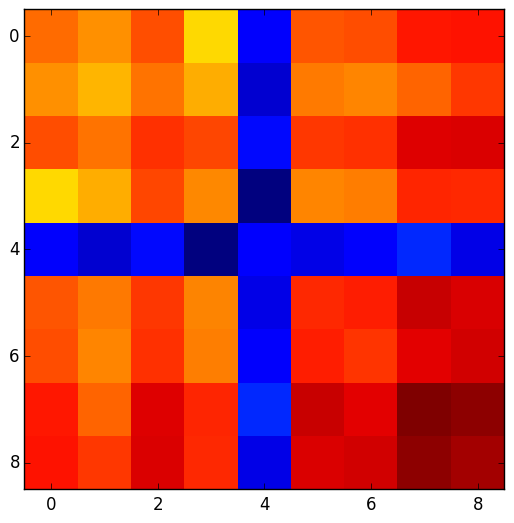

-2.535253940438007
[0.3408884804283812,0.08542855014353434,1.0003691248769675,0.1404998912583652,-2.65795323614477e-13,0.9822273525908096,-1.2967840231752554,10.17539451295826,5.899797264909414]


PyObject <matplotlib.image.AxesImage object at 0x318641310>

In [14]:
### =============== testing 2 ================= ####

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

LL, LLgrad, LLhess = llikey(params)
println(LL)
println(LLgrad)
imshow(log(abs(LLhess)), interpolation="none")
### =========================================== ####

In [15]:
LL

-2.535253940438007

In [16]:
LLgrad

9-element Array{Float64,1}:
  0.340888   
  0.0854286  
  1.00037    
  0.1405     
 -2.65795e-13
  0.982227   
 -1.29678    
 10.1754     
  5.8998     

In [17]:
function multiLikey(ratdata, params, ntrials)
    LL        = 0
    LLgrad    = zeros(size(params))
    LLhessian = zeros(length(params), length(params))
    global RightClickTimes, LeftClickTimes, Nsteps, rat_choice
    
    for i in 1:ntrials
        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, i)
        Nsteps = Int(ceil(maxT/dt))

        LLi, LLgradi, LLhessiani = llikey(params)
#         LL        = LL + LLi;
#         LLgrad    = LLgrad + LLgradi;
#         LLhessian = LLhessian + LLhessiani;

        println(i, " - LL : " , LLi)
        println(LLgradi)
        
    end

#     return LL, LLgrad, LLhessian
end

multiLikey (generic function with 1 method)

In [18]:
epsilon = 10.0^(-10); 
dx = 0.25; 
dt = 0.02; 

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]

@time multiLikey(ratdata, params, 10)

1 - LL : -2.535253940438007
[0.3408884804283812,0.08542855014353434,1.0003691248769675,0.1404998912583652,-2.65795323614477e-13,0.9822273525908096,-1.2967840231752554,10.17539451295826,5.899797264909414]
2 - LL : -0.24006876781027836
[-0.061040662902014854,-0.02138414271916966,-0.1792618185898222,0.02816890375744388,-1.3554859172396418e-15,-0.3546817263974358,0.6320967583233732,-3.93375526632908,-0.40481301425125815]
3 - LL : -0.05311161191567428
[-0.003426543829684014,-0.0007926128546647258,-0.01318467368332751,-0.0005080743358234592,3.0273497217201077e-19,-0.007503775549695543,0.018526590280367943,-0.13573247341576974,-0.5252514785556288]
4 - LL : -2.8357915790470343
[0.16357421161071303,0.03579780832059416,0.9086110609700145,0.027513415064364968,8.383930742064291e-18,-0.48947051186233276,-0.7323934992222421,7.223391931625445,8.357714747470494]
5 - LL : -0.18695198817146225
[-0.04299962874825896,-0.014543805986037677,-0.26788699770088475,0.0006605518700959445,-3.028374817994836e-18,0

In [ ]:
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

@profile multiLikey(ratdata, params, 10)

In [ ]:
Pkg.update()